In [89]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch.nn import Linear, Sigmoid, Tanh, Sequential
from torch.optim.sgd import SGD
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

import math
import matplotlib.pyplot as plt

In [90]:
np.random.seed(1024)
X, y = make_moons(n_samples=1000, noise=0.1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape, y.shape, X.mean(), X.var()

((1000, 2),
 (1000,),
 np.float64(-2.673417043297377e-16),
 np.float64(1.0000000000000002))

In [92]:
batch_size = 1000
X, y = th.tensor(X, dtype=th.float32), th.tensor(y, dtype=th.int64)
dataset = TensorDataset(X, y.unsqueeze(1))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
n_hidden = 100  # 为了得到统计规律，将网络参数量扩大
activation = Sigmoid()  # Tanh()
# model = Sequential(
#     Linear(2, n_hidden),
#     activation,
#     Linear(n_hidden, n_hidden),
#     activation,
#     Linear(n_hidden, n_hidden),
#     activation,
#     Linear(n_hidden, n_hidden),
#     activation,
#     Linear(n_hidden, 2),
# )
model = Sequential(
    Linear(2, n_hidden),
    BatchNorm1d(n_hidden),
    activation,
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    activation,
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    activation,
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    activation,
    Linear(n_hidden, 2),
)
optimizer = SGD(model.parameters(), lr=0.1)

# 权重初始化
for p in model.parameters():
    if p.ndim == 2:
        nn.init.normal_(p)

model.train()
max_epochs = 10
print_interval = max_epochs // 10
# 记录各层梯度更新幅度
gui = {}
for epoch in range(max_epochs):
    for i, (X_batch, y_batch) in enumerate(dataloader):
        y_hat = model(X_batch)
        loss = F.cross_entropy(y_hat, y_batch.squeeze(), reduction="mean")
        model.zero_grad()
        loss.backward()
        optimizer.step()
        with th.no_grad():
            for j, param in enumerate(model.parameters()):
                if param.grad is not None:
                    gui[j] = gui.get(j, []) + [
                        param.grad.std().item() / param.std().item()
                    ]
                else:
                    raise ValueError(f"param.grad is None at {j}")
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item()*1e2:.4f}")

Epoch 1/10, Loss: 256.5876
Epoch 2/10, Loss: 49.9479
Epoch 3/10, Loss: 29.3483
Epoch 4/10, Loss: 22.7686
Epoch 5/10, Loss: 26.1642
Epoch 6/10, Loss: 19.7846
Epoch 7/10, Loss: 21.4950
Epoch 8/10, Loss: 17.9044
Epoch 9/10, Loss: 16.9567
Epoch 10/10, Loss: 19.7680


/tmp/ipykernel_36992/711813711.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = th.tensor(X, dtype=th.float32), th.tensor(y, dtype=th.int64)


Layer 2 activation output statistics: Mean=0.5001, Std=0.2191
Max=0.9314, Min=0.0582
Saturation (0.00%): 0.00% close to 0, 0.00% close to 1
Layer 5 activation output statistics: Mean=0.5000, Std=0.2196
Max=0.9214, Min=0.0818
Saturation (0.00%): 0.00% close to 0, 0.00% close to 1
Layer 8 activation output statistics: Mean=0.5000, Std=0.2193
Max=0.9498, Min=0.0644
Saturation (0.00%): 0.00% close to 0, 0.00% close to 1
Layer 11 activation output statistics: Mean=0.4998, Std=0.2193
Max=0.9566, Min=0.0418
Saturation (0.00%): 0.00% close to 0, 0.00% close to 1


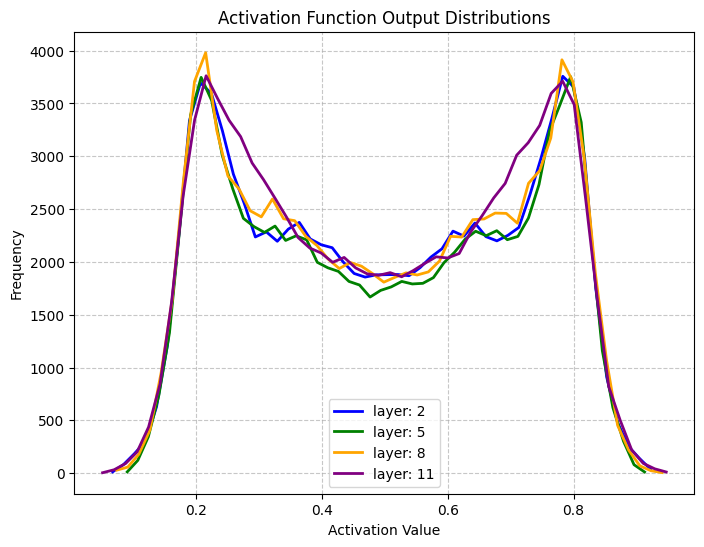

In [93]:
"""
激活函数输出分布情况
"""

activ_out = {}
with th.no_grad():
    out = X
    for i in range(len(model)):
        layer = model[i]
        out = layer(out)
        if isinstance(layer, (Sigmoid, Tanh)):
            activ_out[i] = out.detach().cpu().numpy().flatten()

plt.figure(figsize=(8, 6))
colors = ["blue", "green", "orange", "purple", "brown", "pink"]
for idx, (layer_idx, outputs) in enumerate(activ_out.items()):
    counts, bins = np.histogram(outputs, bins=50)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(
        bin_centers,
        counts,
        label=f"layer: {layer_idx}",
        color=colors[idx % len(colors)],
        linewidth=2,
    )

    # 计算并打印每层的统计信息
    mean_val = np.mean(outputs)
    std_val = np.std(outputs)
    max_val = np.max(outputs)
    min_val = np.min(outputs)

    # 计算饱和度
    saturation_threshold = 0.05
    low_saturation = np.mean(outputs < saturation_threshold) * 100
    high_saturation = np.mean(outputs > (1 - saturation_threshold)) * 100

    print(
        f"Layer {layer_idx} activation output statistics: Mean={mean_val:.4f}, Std={std_val:.4f}"
    )
    print(f"Max={max_val:.4f}, Min={min_val:.4f}")
    print(
        f"Saturation ({(low_saturation+high_saturation):.2f}%): {low_saturation:.2f}% close to 0, {high_saturation:.2f}% close to 1"
    )

plt.title("Activation Function Output Distributions")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [94]:
"""
全连接层权重梯度分布情况
"""

weight_i = {}
with th.no_grad():
    for i in range(len(model)):
        layer = model[i]
        if isinstance(layer, (Linear)):
            for j, param in enumerate(layer.parameters()):
                if param.ndim == 2:  # only consider the weight
                    if param.grad is not None:
                        weight_i[i] = param.grad.detach().cpu().numpy().flatten()
                    else:
                        raise ValueError(
                            f"param.grad is None at layer {i} and param {j}"
                        )

plt.figure(figsize=(8, 6))
colors = ["blue", "green", "orange", "purple", "brown", "pink"]
del weight_i[0]
del weight_i[8]
for idx, (layer_idx, outputs) in enumerate(weight_i.items()):
    counts, bins = np.histogram(outputs, bins=50)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(
        bin_centers,
        counts,
        label=f"layer: {layer_idx}",
        color=colors[idx % len(colors)],
        linewidth=2,
    )

    # 计算并打印每层的统计信息
    mean_val = np.mean(outputs)
    std_val = np.std(outputs)
    max_val = np.max(outputs)
    min_val = np.min(outputs)

    print(
        f"Layer {layer_idx} weight gradient statistics: Mean={mean_val:.4f}, Std={std_val:.4f}"
    )
    print(f"Max={max_val:.4f}, Min={min_val:.4f}")

plt.title("Weight Gradient Distributions")
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(-0.005, 0.005)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

KeyError: 8

<Figure size 800x600 with 0 Axes>

Layer 2 weight value statistics: Mean=0.0117, Std=1.0046
Max=3.8914, Min=-4.1978
Layer 4 weight value statistics: Mean=0.0084, Std=1.0069
Max=4.3734, Min=-3.8663
Layer 6 weight value statistics: Mean=-0.0051, Std=1.0027
Max=3.7965, Min=-3.7894


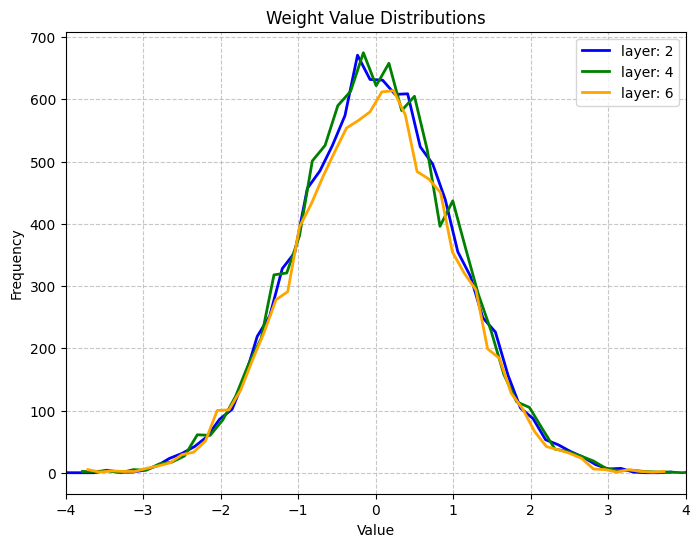

In [87]:
"""
全连接层权重分布情况
"""

weight_i = {}
with th.no_grad():
    for i in range(len(model)):
        layer = model[i]
        if isinstance(layer, (Linear)):
            for j, param in enumerate(layer.parameters()):
                if param.ndim == 2:  # only consider the weight
                    weight_i[i] = param.data.detach().cpu().numpy().flatten()
plt.figure(figsize=(8, 6))
colors = ["blue", "green", "orange", "purple", "brown", "pink"]
del weight_i[0]
del weight_i[8]
for idx, (layer_idx, outputs) in enumerate(weight_i.items()):
    counts, bins = np.histogram(outputs, bins=50)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(
        bin_centers,
        counts,
        label=f"layer: {layer_idx}",
        color=colors[idx % len(colors)],
        linewidth=2,
    )

    # 计算并打印每层的统计信息
    mean_val = np.mean(outputs)
    std_val = np.std(outputs)
    max_val = np.max(outputs)
    min_val = np.min(outputs)

    print(
        f"Layer {layer_idx} weight value statistics: Mean={mean_val:.4f}, Std={std_val:.4f}"
    )
    print(f"Max={max_val:.4f}, Min={min_val:.4f}")

plt.title("Weight Value Distributions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(-4, 4)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

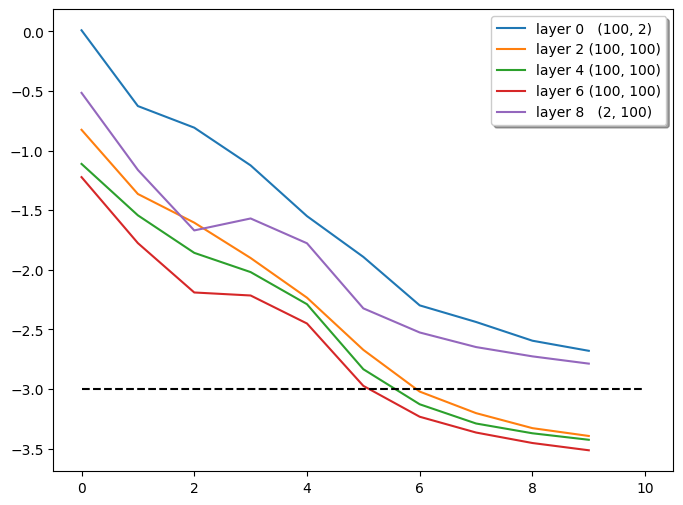

In [88]:
plt.figure(figsize=(8, 6))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 2:
        plt.plot([math.log10(t) for t in gui[i]])
        legends.append(f"layer {i} {str(tuple(p.shape)):>10}")
# 理想的标准线 -> 梯度更新比例在 1e-3 左右最佳
plt.plot([0, len(gui[0])], [-3, -3], "k--")
plt.legend(legends, shadow=True)
plt.show()